## Imports
---

In [73]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
from src.heikin_ashi import heikin_ashi
from src.indicators import supertrend, VWAP2, smc, wavetrend3d, atr, pivotPoints, choch, find_extrema, vwma
from src.backtesting_lib import evaluatePairs, format_data, profitMonthly, profitFactorBars, profitYearly, profitMonthlyYearly, barsWinLoss
import pandas_ta as ta
from scipy.signal import argrelextrema
import csv
import plotly.graph_objects as go
import plotly.express as px
import numba
from numba import jit

## Getting the Data
---

# Kleines Tutorial für Backtesting.py

Es besteht aus einen init part wo alle variablen definiert und initialisiert werden und einen next part wo der algorithmus nach und nach jede candle durchgeht. Dabei kann man die zurzeitige Candle mit __self.data.Close[-1]__ abrufen. Dir davor mit -2 usw. Ihr könnt außerdem dabei zwischen Close, Open, High, Low entscheiden. 

Um die zurzeitige Balance zu bekommen ruft ihr self.equity auf. 

Um Indicatoren hinzuzufügen habt ihr folgende Syntax:

__self.IndicatorName = self.I(Indicator, Parameter1, Parameter2, ...)__

Dabei könnt ihr die jetzigen Werte abrufen wie mit den Daten [-n],  $n \in \mathbb{N}$ .

Um Trades einzugehen bentzt man entweder:

__self.buy(size=deineGroesse)__ 

__self.sell(size=deineGroesse)__

Ihr müsst dabei geachten das man entweder die Share anzahl als Integer übergebt oder die eine Kommazahl von $[0,1)$ die darstellt wie viel Prozent deines Portfolios du reinsetzt hast.

um eine Position zu schließen benutzt ihr: 

__self.position.close()__

Das sind so die wichtigsten Befehle. Leider lässt die libary nicht mehrere Positionen gleichzeitig. Falls ihr das umbedingt braucht kann ich nach einer anderen Libary ausschau halten. 

Falls ihr irgendwelche anderen Befehle braucht wie z.B. eine LimitOrder oder sowas dann findet ihr die unter den Documentations: 

- https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#gsc.tab=0


## The Strategy
---

## CHOCH mit Varianz Filter
---

In [77]:
def choch_numba(higher_high, lower_low, higher_low, lower_high, close, low, high, right, teiler):
    chochLong = np.zeros(len(higher_high))
    chochShort = np.zeros(len(higher_high))
    last_valh = 0
    last_vall = 0
    last_valhh = 0
    last_valll = 0
    last2_valhh = 0
    last2_valll = 0
    valh_candle = 0
    vall_candle = 0
    last_trade = 0
    candlecount = 0
    close_new = pd.Series(close)
    var = close_new.rolling(window=8, min_periods=8).var()
    avg_var = var.mean() / teiler
    for i in range(len(higher_high)):
        current_var = var.iloc[i]
        if higher_high[i] > 0:
            last2_valhh = last_valhh
            last_valhh = higher_high[i]
        if lower_low[i] > 0:
            last2_valll = last_valll
            last_valll = lower_low[i]
        if higher_low[i] > 0:
            last_valh = higher_low[i]
            valh_candle = candlecount
        if lower_high[i] > 0:
            last_vall = lower_high[i]
            vall_candle = candlecount
        if  high[i] > last_vall and current_var > avg_var and close[i] < last_vall and candlecount - vall_candle < 10 and candlecount - vall_candle > right and last_trade > 10 and low[i - 5] < high[i] and last2_valhh > last_valhh:
            chochLong[i] = close[i]
            last_vall = 0
            vall_candle = 0
            last_trade = 0
        if  low[i] < last_valh and current_var > avg_var and close[i] > last_valh and candlecount - valh_candle < 10 and candlecount - valh_candle > right and last_trade > 10 and high[i - 5] > low[i] and last2_valhh < last_valhh:
            chochShort[i] = close[i]
            last_valh = 0
            valh_candle = 0
            last_trade = 0

        last_trade += 1
        candlecount += 1

    return chochShort, chochLong


def choch(df, left, right,teiler,  timeframe="3T", sholong=0):
    if timeframe != "3T":
        df = df.resample(timeframe).agg({"Open": "first", "High": "max", "Low": "min", "Close": "last"})
    
    highs_lows = find_extrema(df, left, right)
    df["higher_high"] = highs_lows["higher_high"]
    df["lower_low"] = highs_lows["lower_low"]
    df["higher_low"] = highs_lows["higher_low"]
    df["lower_high"] = highs_lows["lower_high"]
    
    lower_high = df["lower_high"].to_numpy()
    higher_low = df["higher_low"].to_numpy()
    higher_high = df["higher_high"].to_numpy()
    lower_low = df["lower_low"].to_numpy()
    close = df["Close"].to_numpy()
    low = df["Low"].to_numpy()
    high = df["High"].to_numpy()

    chochShort, chochLong = choch_numba(higher_high, lower_low, higher_low, lower_high, close, low, high, right, teiler)

    if sholong == 0:
        return chochShort
    else:
        return chochLong


In [52]:
choch(auxusd, 10, 10, "3T", 1)

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
von = 100
bis = 200

auxusd = format_data("AUXUSD")

left_cand = 6
right_cand = 3

fig = go.Figure(data=[go.Candlestick(x=auxusd[von:bis].index,
                open=auxusd['Open'][von:bis],
                high=auxusd['High'][von:bis],
                low=auxusd['Low'][von:bis],
                close=auxusd['Close'][von:bis])])
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["higher_high"][von:bis], mode="markers", marker=dict(color="blue", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["lower_low"][von:bis], mode="markers", marker=dict(color="pink", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["higher_low"][von:bis], mode="markers", marker=dict(color="orange", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["lower_high"][von:bis], mode="markers", marker=dict(color="brown", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=np.where(choch(auxusd, 20, 3) == 0, np.nan, choch(auxusd, 20, 3))[von:bis], mode="markers", marker=dict(color="black", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=np.where(choch(auxusd, 20, 3, "3T", 1) == 0, np.nan, choch(auxusd, 20, 3, "3T", 1))[von:bis], mode="markers", marker=dict(color="darkgreen", size=8))
fig.update_layout(xaxis_rangeslider_visible=False, width=800)
fig.show()

In [59]:
idk = auxusd["Close"].rolling(8).var()
idk.mean()

0.9612462904766542

# ChoCh Strat mit VWAP
---

In [76]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import warnings

warnings.filterwarnings("ignore")

class chocho(Strategy):
    shorts = True
    longs = True
    tradehourStart = 1 #UTC Time
    tradehourEnd = 20 #UTC Time
    timebetween = False # An schalter damit das Intervall funktioniert
    donttrade = 13 # Intervall anfang wo er nicht traden soll
    donttrade2 = 16-1 # Intervall ende wo er nicht traden soll
    timeframeChoch = "3T"
    chochLeft = 40
    chochRight = 3
    stoplosscandles = 8
    atr_window = 14
    uuvwap = False # Macht nur trades wenn der Kurs über dem VWAP ist (oder unter)
    uu1vwap = True # Für die 1. Deviation als range für trade entry
    supertrendlookback = 10
    supertrendmultiplier = 3
    vwmaoff = True
    teilerfürchoch = 2
    vwmaLength = 60
    taggedduration = 7
    vwmaduration = 2
    atr_threshold = 0
    close22 = False
    multiple_positions = False

    def init(self):
        self.sholong = 0
        self.lastdiffs = []
        self.stoploss = 0
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.taggedshort = False
        self.taggedlong = False
        self.taggedcountershort = 0 # How long a tag is valid to enter with chocho
        self.taggedcounterlong = 0 
        self.fees = 0
        self.entryal = False
        self.index = 0
        self.vwmacounter = 0
        self.length = len(self.data.df)
        self.vwapu1 = self.I(VWAP2, self.data.df, 1)
        self.vwapl1 = self.I(VWAP2, self.data.df, 2)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        self.vwma = self.I(vwma, self.data.Close, self.data.Volume, self.vwmaLength)
        self.chochLong = self.I(choch, self.data.df, self.chochLeft, self.chochRight,self.teilerfürchoch, self.timeframeChoch, 1)
        self.chochShort = self.I(choch, self.data.df, self.chochLeft, self.chochRight,self.teilerfürchoch, self.timeframeChoch, 0)
        self.supertrendu = self.I(supertrend, self.data.df, self.supertrendlookback, self.supertrendmultiplier, 0)
        self.supertrendl = self.I(supertrend, self.data.df, self.supertrendlookback, self.supertrendmultiplier, 1)
        self.atr = self.I(atr, self.data.df, self.atr_window)

        
    def next(self):
        if self.data.index[-1].hour >= self.tradehourStart and self.data.index[-1].hour < self.tradehourEnd and (self.data.index[-1].hour < self.donttrade or self.data.index[-1].hour > self.donttrade2 or not self.timebetween) and (not self.position or self.multiple_positions):
            if self.shorts:
                if not self.taggedshort:
                    if ((self.data.High[-1] > self.vwapu2[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)) or (self.data.High[-1] > self.vwapu3[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu3[-1] + (self.atr[-1]/2))):
                        self.taggedshort = True
                elif (self.chochShort[-1] > 0 and self.atr[-1] > self.atr_threshold and self.taggedshort and self.taggedcountershort < self.taggedduration and (self.data.Close[-1] > self.vwap[-1] or not self.uuvwap) and (self.data.Close[-1] > self.vwapl1[-1] or not self.uu1vwap)) or self.entryal:
                    self.entryal = True
                    if (self.data.Low[-1] < self.vwma[-1] and self.data.High[-1] > self.vwma[-1] and self.vwmacounter < self.vwmaduration) or self.vwmaoff:
                        self.stoploss = 0
                        for i in range(1, self.stoplosscandles):
                            if self.data.High[-i] > self.stoploss:
                                self.stoploss = self.data.High[-i]
                        def berechnen(kapital, stoploss, entry):
                            diff = abs(stoploss - entry)
                            if(diff < 0.0000001):
                                diff = abs(sum(self.lastdiffs) / len(self.lastdiffs))
                            self.lastdiffs.append(diff)
                            size = abs((kapital/100) / abs(diff))
                            return int(round(size,0))
                        sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                        self.sell(size=sizeO, sl=self.stoploss)
                        self.sholong = 1
                        self.entryal = False
                    elif self.vwmacounter >= self.vwmaduration:
                        self.entryal = False
                        self.vwmacounter = 0
                    else:
                        self.vwmacounter += 1
                if self.taggedshort:
                    self.taggedcountershort += 1
                if self.taggedcountershort > self.taggedduration:
                    self.taggedshort = False    
                    self.taggedcountershort = 0
            if self.longs and not self.position:
                if not self.taggedlong:
                    if((self.data.Low[-1] < self.vwapl2[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)) or (self.data.Low[-1] < self.vwapl3[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl3[-1] - (self.atr[-1]/2))):
                        self.taggedlong = True
                if (self.chochLong[-1] > 0 and self.atr[-1] > self.atr_threshold and self.taggedlong and self.taggedcounterlong < self.taggedduration and (self.data.Close[-1] < self.vwap[-1] or not self.uuvwap) and (self.data.Close[-1] < self.vwapu1[-1] or not self.uu1vwap)) or self.entryal:
                    self.entryal = True
                    if (self.data.Low[-1] < self.vwma[-1] and self.data.High[-1] > self.vwma[-1] and self.vwmacounter < self.vwmaduration) or self.vwmaoff:
                        self.stoploss = 10000000
                        for i in range(1, self.stoplosscandles):
                            if self.data.Low[-i] < self.stoploss:
                                self.stoploss = self.data.Low[-i]
                        def berechnen(kapital, stoploss, entry):
                            diff = abs(stoploss - entry)
                            if(diff < 0.0000001):
                                diff = abs(sum(self.lastdiffs) / len(self.lastdiffs))
                            self.lastdiffs.append(diff)
                            size = abs((kapital/100) / abs(diff))
                            return int(round(size,0))
                        sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                        self.buy(size=sizeO, sl=self.stoploss)
                        self.sholong = 0
                        self.entryal = False
                    elif self.vwmacounter >= self.vwmaduration:
                        self.entryal = False
                        self.vwmacounter = 0
                    else:
                        self.vwmacounter += 1
                if self.taggedlong:
                    self.taggedcounterlong += 1
                if self.taggedcounterlong > self.taggedduration:
                    self.taggedlong = False
                    self.taggedcounterlong = 0
        elif self.position:
            if self.sholong == 0:
                if(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0):
                    self.position.close()
                    self.tagged = False
            elif self.sholong == 1:
                if(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0):
                    self.position.close()
                    self.tagged = False
            if self.data.index[-1].hour >= 22 and self.close22:
                self.position.close()
                self.trades.index
                self.tagged = False

data = format_data("USDJPY", "3T")

bt = Backtest(data, chocho, cash=10000, commission=0.000045, margin=0.01)
stats = bt.run()
stats

Start                     2013-06-05 00:00:00
End                       2023-06-03 12:24:00
Duration                   3650 days 12:24:00
Exposure Time [%]                    4.768182
Equity Final [$]                155902.465014
Equity Peak [$]                 175381.987577
Return [%]                         1459.02465
Buy & Hold Return [%]               39.878453
Return (Ann.) [%]                    24.48403
Volatility (Ann.) [%]               31.289095
Sharpe Ratio                          0.78251
Sortino Ratio                        2.584217
Calmar Ratio                         0.666315
Max. Drawdown [%]                  -36.745422
Avg. Drawdown [%]                   -2.596365
Max. Drawdown Duration      717 days 14:03:00
Avg. Drawdown Duration       11 days 19:27:00
# Trades                                 1461
Win Rate [%]                        37.303217
Best Trade [%]                       3.851731
Worst Trade [%]                     -0.505871
Avg. Trade [%]                    

In [54]:
bt.plot()

GridPlot(id='p5857', ...)

# Chart Part
---

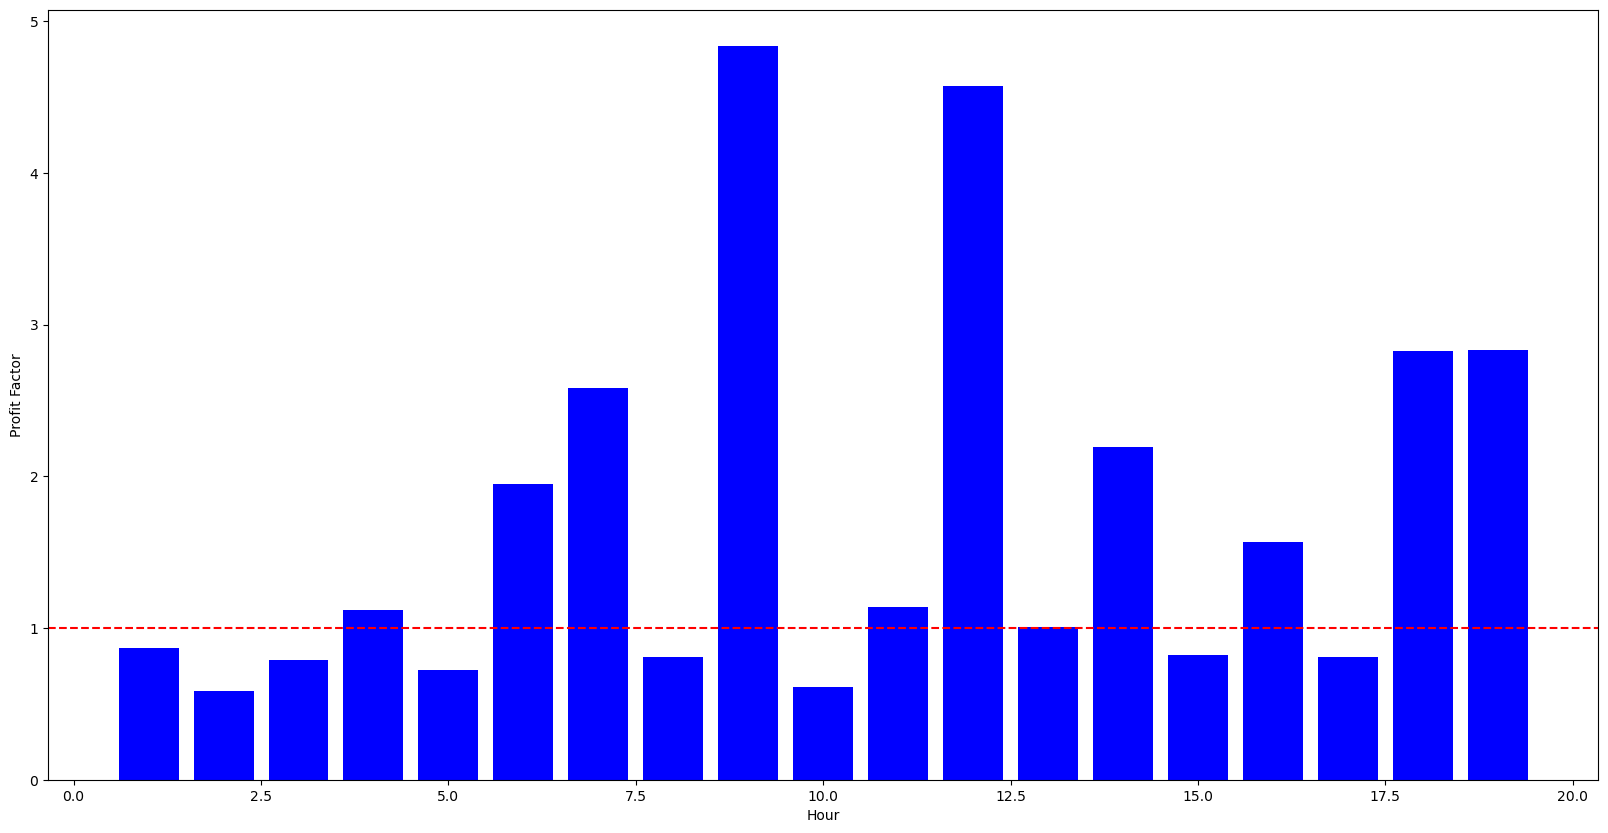

In [4]:
profitFactorBars(stats)

Year  Month
2021  6         1643.438385
      7           63.812558
      8        -2400.640607
      9         2182.439157
      10        1690.061160
      11       -1831.235162
      12       -1958.897849
2022  1          847.901014
      2         1287.663006
      3         4076.376030
      4         3124.486617
      5         -108.055145
      6        10340.104702
      7          507.537171
      8          246.363201
      9         1740.387176
      10        7422.804052
      11       11697.753267
      12          98.063087
2023  1         9187.333829
      2         3669.924877
      3        12010.008091
      4        13803.971115
      5        21963.284509
Name: PnL, dtype: float64

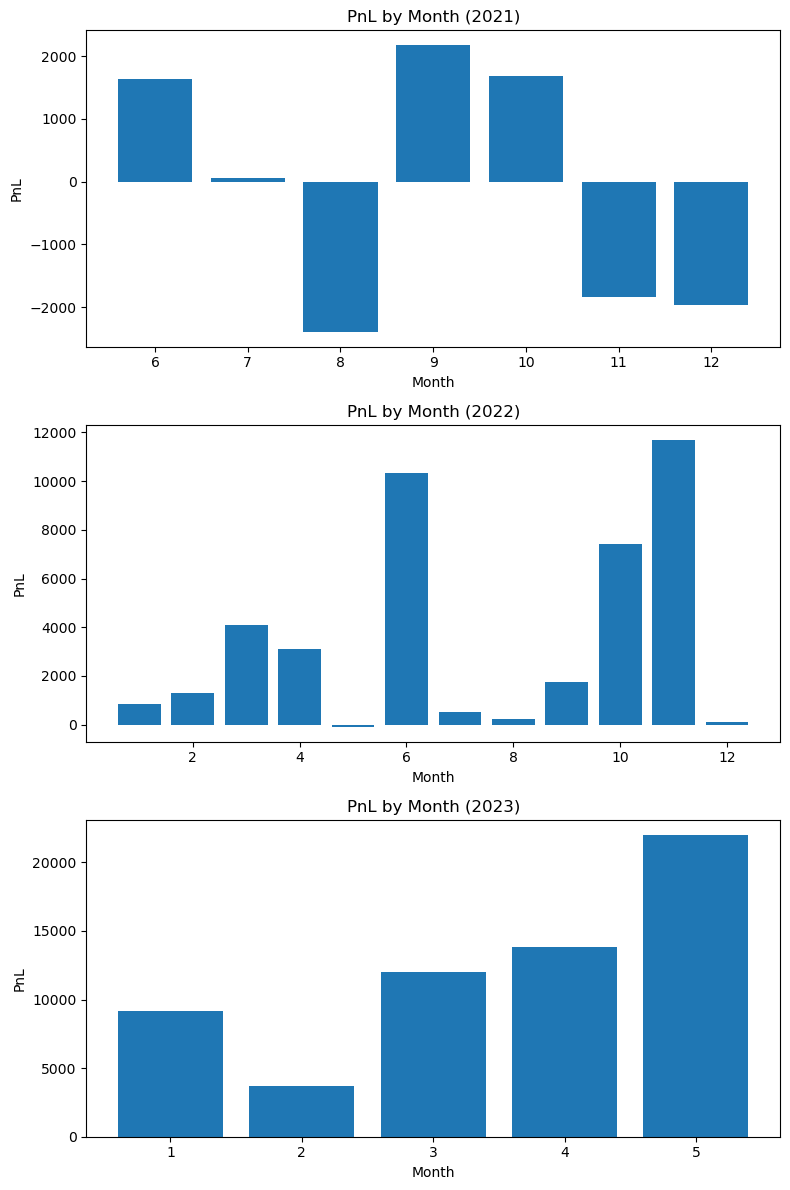

In [5]:
profitMonthlyYearly(stats)

In [ ]:
profitFactorBars(stats)

In [ ]:
profitMonthly(stats)

In [ ]:
barsWinLoss(stats)

# Parameter Optimization
---

In [ ]:

data = format_data("EURUSD_NEW", "3T")

bt = Backtest(data[-300000:], chocho, cash=10000, commission=0.00003, margin=0.01)
output = bt.run()

stats, heatmap = bt.optimize(
    supertrendlookback = range(5, 50, 5),
    supertrendmultiplier = range(3, 10, 1),
    maximize='Sharpe Ratio',
    max_tries=100,
    return_heatmap=True,
    random_state=0,
)

## Get 3 best results

In [ ]:
hm = heatmap.groupby(['supertrendlookback', 'supertrendmultiplier']).mean().unstack()
hm

In [ ]:
%matplotlib inline

sns.heatmap(hm[::1], cmap='viridis')

# Backtesting multiple pairs at the same time
---

In [ ]:
pairsList = ["AUDCAD", "AUDCHF", "AUDJPY", "AUDNZD", "AUDUSD", "CADCHF", "CADJPY", "CHFJPY", "EURAUD", "EURCAD", "EURCHF", "EURGBP", "EURJPY", "EURNZD", "EURUSD", "GBPAUD", "GBPCAD", "GBPCHF", "GBPJPY", "GBPNZD", "GBPUSD", "NZDCAD", "NZDCHF", "NZDJPY", "NZDUSD", "USDCAD", "USDCHF", "USDJPY"]
 
evaluatePairs(pairsList, chocho)